In [1]:
# General libraries
from utils.hamiltonian_utils import ising_chain_ham
from utils.rotosolve_optimizer import Rotosolve
from scipy.ndimage import gaussian_filter
import json
from styles.style import qspain
from IPython.display import Latex
from IPython import display
import matplotlib.pyplot as plt
import warnings

# Qiskit libraries
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit import Aer
from qiskit.circuit.library import TwoLocal
from qiskit import transpile
from qiskit.algorithms.optimizers import SPSA
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeLima
from qiskit_aer import QasmSimulator
from qiskit.primitives import Estimator
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit_ibm_provider import least_busy
from qiskit_ibm_provider import IBMProvider as IBMQ
import qiskit.tools.jupyter

# Pennylane libraries
import pennylane as qml
from pennylane import numpy as np
from utils.pennylane_utils import print_pennylane_circuit, convert_vqe_to_dict

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# Vista del archivo rotosolve_optimizer.py
display.Code("./utils/rotosolve_optimizer.py")

"""
Created by: QuantumSpain (https://quantumspain-project.es/)
"""
from qiskit.algorithms.optimizers.optimizer import Optimizer, OptimizerSupportLevel, OptimizerResult
import numpy as np
from typing import Dict, Any

class Rotosolve(Optimizer):
    """Create an instance of the Rotosolve optimizer.
    Parameters
    ----------
    max_steps : int
        Maximum number of steps to take in the optimizer. This is the number
        of times to loop through all the parameters in the objective function.
    alt_convention : bool
        The Rotosolve paper uses the convention that there is a `1/2`
        in the exponent. This convention corresponds to `alt_convention=False`.
        In other algorithms this factor is
        not present, in which case, use `alt_convention=True`.
    step_size : int
        The step count in the value optimization loop.
    See: https://arxiv.org/abs/1905.09692
    """

    CONFIGURATION = {
        'name': 'RotoSolve',
        'description': 'RotoSolve Optimizer',
        'input_schema': {
            '$schema': 'http://json-schema.org/schema#',
            'id': 'GP_schema',
            'type': 'object',
            'properties': {},
            'additionalProperties': False
        },
        'support_level': {
            'gradient': OptimizerSupportLevel.ignored,
            'bounds': OptimizerSupportLevel.ignored,
            'initial_point': OptimizerSupportLevel.supported
        },
        'options': [],
        'optimizer': [],
        'maxiter': 1024
    }

    def __init__(self, max_steps: int = 10, step_size: int = 1, alt_convention: bool = False):
        
        super().__init__()
        
        self._max_steps = max_steps
        self._step_size = step_size
        
        # alt_convention == False:
        # e^{-i H theta}
        # alt_convention == True
        # e^{-i H theta/2}
        self._alt_convention = alt_convention

    def optimize(self, num_vars, obj_function, gradient_function=None, variable_bounds=None, initial_point=None):
        """See `qiskit.algorithms.optimizers.optimizer.Optimizer` documentation."""
        super().optimize(num_vars, obj_function, gradient_function, variable_bounds, initial_point)

        if initial_point is None:
            initial_point = np.random.uniform(-np.pi, +np.pi, num_vars)
            
        return self.minimize(fun = obj_function, x0 = initial_point)

    def minimize(self, fun, x0, bounds = None, jac = None):
    
        factor = 2 if self._alt_convention else 1

        def f(x):
            return fun(x / factor)
        
        theta_min, f_min, f_evals, f_values =  self._rotosolve(f, x0, self._max_steps, self._step_size)
        
        self.energy_values = f_values
        
        result = OptimizerResult()
        result.x = theta_min # optimal parameters
        result.fun = f_min # optimal function value
        result.nfev = f_evals

        return result
    
    @staticmethod
    def _rotosolve(f, initial_point: np.array, max_steps: int, step_size: int):
        
        D = len(initial_point)
        theta = initial_point
        f_evals = 0
        
        def f_counter(*args, **kwargs):
            return f(*args, **kwargs)

        f_current = f_counter(initial_point)
        f_evals += 1
        
        converged = False
        steps = 0

        theta_values = []
        f_values = []
        
        print("Rotosolve algorithm for optimizing a given value")
        print("================================================")
        
        while not converged:
            
            for d in range(D):
                
                phi = np.random.uniform(-np.pi, +np.pi)
                theta_d = phi
                theta[d] = theta_d
                m_vals = {
                    'phi+0': 0,
                    'phi+pi/2': 0,
                    'phi-pi/2': 0
                }

                m_vals['phi+0'] = f_counter(theta)
                f_evals += 1
                theta[d] = theta[d]

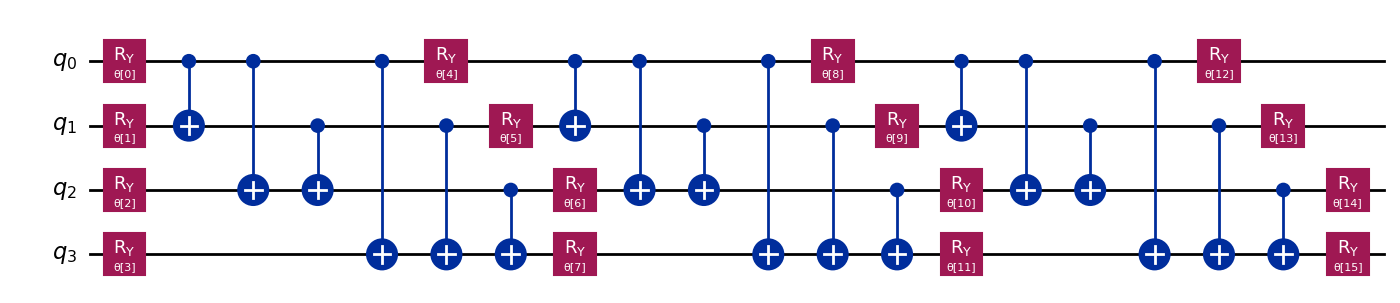

In [3]:
'''Qiskit_code_cell'''

# Definimos el Hamiltoniano
n = 4 
gam = 0.3

op_H = ising_chain_ham(n, gam) # Creamos el Hamiltoniano descrito

ansatz = TwoLocal(num_qubits=n, rotation_blocks='ry', entanglement_blocks='cx')
ansatz.draw('mpl', style='iqx')

ansatz.decompose().draw('mpl', style='iqx')

In [4]:
'''Qiskit_code_cell'''

seed = 63
np.random.seed(seed) # seed for reproducibility
algorithm_globals.random_seed = seed

# Instanciamos la clase Rotosolve con 200 iteraciones como máximo y un paso de 3
# en total serán 200/3 = 66 iteraciones
optimizer = Rotosolve(max_steps = 200, step_size = 3)

initial_point = np.random.random(ansatz.num_parameters) # valor inicial

intermediate_info = {
    'nfev': [],
    'parameters': [],
    'mean': [],
    #'stddev': []
}

def callback(nfev, parameters, mean, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['mean'].append(mean)
    #intermediate_info['stddev'].append(stddev)

backend = Aer.get_backend('aer_simulator')

qi = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

vqe_min = VQE(estimator = Estimator(),
           ansatz=ansatz,
           optimizer=optimizer,
           initial_point=initial_point,
           callback=callback)

vqe_min.quantum_instance = qi

result = vqe_min.compute_minimum_eigenvalue(op_H)

print('\nEigenvalue:', result.eigenvalue)
print('Eigenvalue real part:', result.eigenvalue.real)

print(result, "\n")
print("E_G =", result.optimal_value)

Rotosolve algorithm for optimizing a given value
Step 0. Current expectation value: -3.86172400


Step 3. Current expectation value: -4.06494515


Step 6. Current expectation value: -4.08179742
Step 9. Current expectation value: -4.08555553


Step 12. Current expectation value: -4.08710498
Step 15. Current expectation value: -4.08812628


Step 18. Current expectation value: -4.08886023
Step 21. Current expectation value: -4.08937372


Step 24. Current expectation value: -4.08972181
Step 27. Current expectation value: -4.08995283


Step 30. Current expectation value: -4.09010424
Step 33. Current expectation value: -4.09020279


Step 36. Current expectation value: -4.09026674
Step 39. Current expectation value: -4.09030819


Step 42. Current expectation value: -4.09033508
Step 45. Current expectation value: -4.09035256


Step 48. Current expectation value: -4.09036394
Step 51. Current expectation value: -4.09037137


Step 54. Current expectation value: -4.09037623
Step 57. Current expectation value: -4.09037943


Step 60. Current expectation value: -4.09038153
Step 63. Current expectation value: -4.09038292


Step 66. Current expectation value: -4.09038385
Step 69. Current expectation value: -4.09038446


Step 72. Current expectation value: -4.09038487
Step 75. Current expectation value: -4.09038514


Step 78. Current expectation value: -4.09038532
Step 81. Current expectation value: -4.09038544


Step 84. Current expectation value: -4.09038552
Step 87. Current expectation value: -4.09038558


Step 90. Current expectation value: -4.09038562
Step 93. Current expectation value: -4.09038564


Step 96. Current expectation value: -4.09038566
Step 99. Current expectation value: -4.09038567


Step 102. Current expectation value: -4.09038568
Step 105. Current expectation value: -4.09038568


Step 108. Current expectation value: -4.09038569
Step 111. Current expectation value: -4.09038569


Step 114. Current expectation value: -4.09038569
Step 117. Current expectation value: -4.09038569


Step 120. Current expectation value: -4.09038569
Step 123. Current expectation value: -4.09038569


Step 126. Current expectation value: -4.09038569
Step 129. Current expectation value: -4.09038569


Step 132. Current expectation value: -4.09038569
Step 135. Current expectation value: -4.09038569


Step 138. Current expectation value: -4.09038569
Step 141. Current expectation value: -4.09038569


Step 144. Current expectation value: -4.09038569
Step 147. Current expectation value: -4.09038569


Step 150. Current expectation value: -4.09038569
Step 153. Current expectation value: -4.09038569


Step 156. Current expectation value: -4.09038569
Step 159. Current expectation value: -4.09038569


Step 162. Current expectation value: -4.09038569
Step 165. Current expectation value: -4.09038569


Step 168. Current expectation value: -4.09038569
Step 171. Current expectation value: -4.09038569


Step 174. Current expectation value: -4.09038569
Step 177. Current expectation value: -4.09038569


Step 180. Current expectation value: -4.09038569


Step 183. Current expectation value: -4.09038569
Step 186. Current expectation value: -4.09038569


Step 189. Current expectation value: -4.09038569
Step 192. Current expectation value: -4.09038569


Step 195. Current expectation value: -4.09038569
Step 198. Current expectation value: -4.09038569

Eigenvalue: -4.090385692923965
Eigenvalue real part: -4.090385692923965
{   'aux_operators_evaluated': None,
    'cost_function_evals': 3218,
    'eigenvalue': -4.090385692923965,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x7f4b0775f890>,
    'optimal_parameters': {   ParameterVectorElement(θ[15]): tensor(0.15027838, requires_grad=True),
                              ParameterVectorElement(θ[0]): tensor(3.13633367, requires_grad=True),
                              ParameterVectorElement(θ[4]): tensor(0.00123403, requires_grad=True),
                              ParameterVectorElement(θ[14]): tensor(0.80719253, requires_grad=True),
                              ParameterVectorElement(θ[13]): tensor(0.13749722, requires_grad=True),
                              ParameterVectorElement(θ[12]): tensor(0.87294481, requires_grad=True),
                

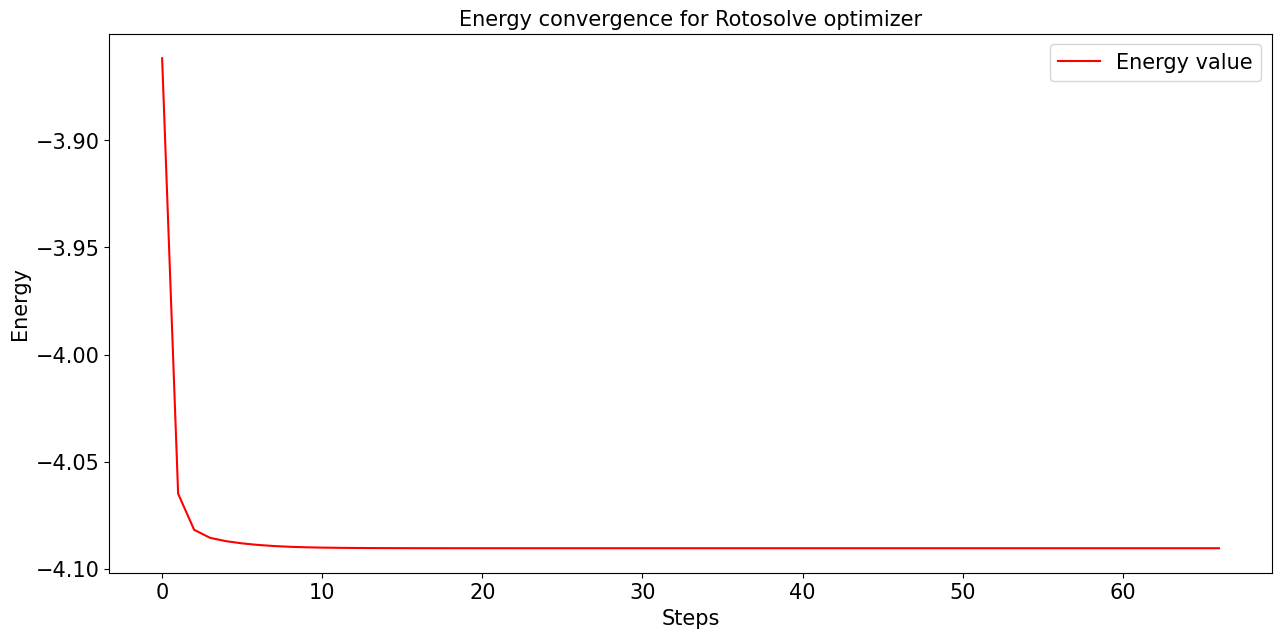

In [5]:
'''Qiskit_code_cell'''

sim_values = optimizer.energy_values
fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(sim_values)), sim_values, label="Energy value", color='red')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Steps', fontsize = fontsize)
plt.ylabel('Energy', fontsize = fontsize)
plt.title('Energy convergence for Rotosolve optimizer', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize);
plt.show()

In [6]:
'''Qiskit_code_cell'''

# Incluye aquí el token personal de ibmq --> https://quantum-computing.ibm.com/
QISKIT_TOKEN = "" 

# Configuración de ejecución
CONFIGURATION = {
    'USE_REAL_BACKEND_NOISE': False, # Usa o no el backend real de ibmq_lima para obtener el ruido del dispositivo para la simulacion VQE
    'JSON_RESULT': True, # Usa los resultados obtenidos de una ejecución previa del algoritmo VQE en el dispositivo real ibmq_lima, desactivar esta opción puede hacer que la ejecución de VQE tarde horas
}

In [7]:
'''Qiskit_code_cell'''

if not CONFIGURATION['USE_REAL_BACKEND_NOISE']:
    
    # Use FakeLima device (fake device)
    print("Using fake ibmq_lima device...\n")
        
    device_backend = FakeLima()
    backend = QasmSimulator.from_backend(device_backend)
    
else:

    if QISKIT_TOKEN != "":
        IBMQ.save_account(QISKIT_TOKEN, overwrite=True)
        print("Token IBMQ guardado!")
    #else:
    #    pass # Skip token check
    #    raise("Token no encontrado. Regístrate en https://quantum-computing.ibm.com/ para obtener el token y usar un backend real")
        
    print("Token activo!\n")
    
    provider = IBMQ()

    provider.backends(simulator=False, operational=True)

    print("Provider seleccionado: ", provider.active_account()['instance'])

    # Seleccionamos el backend que este disponible acorde a nuestra configuración
    #backend = least_busy(provider.backends(filters = lambda b: b.configuration().n_qubits >= n and 
    #                                             b.status().operational and not b.configuration().simulator))

    # Obtenemos el backend ibmq_lima
    backend = provider.get_backend('ibm_osaka')

    # Use ibmq_lima real device
    print("\nUsando el backend '%s'..." % (backend.configuration().backend_name))

Using fake ibmq_lima device...



In [8]:
'''Qiskit_code_cell'''

# El proceso de procesado de VQE en un computador cuántico real es my costoso (puede durar horas) y tiene timeout en el servidor
# podemos cargar los resultados de una ejecución previa de VQE preparado en un JSON
if not CONFIGURATION['JSON_RESULT']:

    intermediate_info = {
        'nfev': [],
        'parameters': [],
        'energy': [],
        #'stddev': []
    }
    
    def callback(nfev, parameters, mean, stddev):
        intermediate_info['nfev'].append(nfev)
        intermediate_info['parameters'].append(parameters)
        intermediate_info['energy'].append(mean)
        #intermediate_info['stddev'].append(stddev)
    
    basis_gates = backend.configuration().basis_gates
    
    # Transpilación del circuito ansatz para su representación en función de las puertas base del backend
    trans_ansatz = transpile(ansatz, basis_gates = basis_gates, optimization_level = 0)

    # No podemos enviar el algoritmo rotosolve a un ordenador real porque qiskit no lo tiene implementado
    # si enviamos el programa de VQE con rotosolve nos devolverá un error 
    optimizer_real = SPSA(maxiter = 300)
    
    vqe_min_real = VQE(estimator = Estimator(),
                       ansatz = trans_ansatz,
                       optimizer = optimizer_real, 
                       initial_point = initial_point,
                       callback = callback)
    
    vqe_min_real.quantum_instance = QuantumInstance(backend, seed_transpiler=63, seed_simulator=63)
    
    result = vqe_min_real.compute_minimum_eigenvalue(op_H)
    eigenvalue = result.eigenvalue
    optimal_value = result.optimal_value
    
else:

    # Ejecución previa de VQE con SPSA y 300 iteraciones en el backend ibmq_osaka
    # Recuperamos la ejecución, job id: cf5f7poi10jrivgn92ag
    with open('./utils/results/cf5f7poi10jrivgn92ag-result.json') as user_file:
        json_dict = user_file.read()

    result = json.loads(json_dict)
    
    eigenvalue = complex(result['eigenvalue']['__value__'][0], result['eigenvalue']['__value__'][1])
    optimal_value = result['optimal_value']
    
print('Eigenvalue:', eigenvalue)
print('Eigenvalue real part:', np.real(eigenvalue))
print("E_G =", optimal_value)

Eigenvalue: (-0.8261718749999999+0j)
Eigenvalue real part: -0.8261718749999999
E_G = -0.8261718749999999


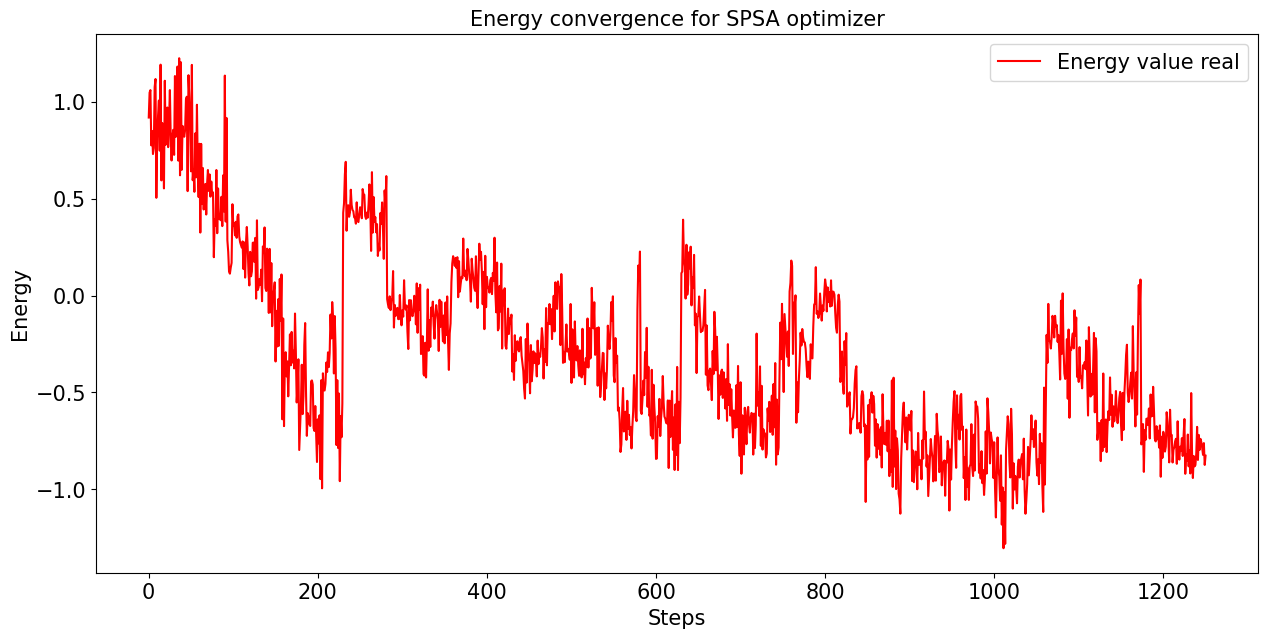

In [9]:
'''Qiskit_code_cell'''

plot_values = intermediate_info['energy'] if not CONFIGURATION['JSON_RESULT'] else result['optimizer_history']['energy']
fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(plot_values)), plot_values, label="Energy value real", color='red')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Steps', fontsize = fontsize)
plt.ylabel('Energy', fontsize = fontsize)
plt.title('Energy convergence for SPSA optimizer', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize);
plt.show()

In [10]:
'''Qiskit_code_cell'''

noise_model = NoiseModel.from_backend(backend) # modelo de ruido
coupling_map = backend.configuration().coupling_map # configuración de conexiones de puertas cuánticas
basis_gates = noise_model.basis_gates # puertas básicas

#print(noise_model)
print("\nCoupling map: ", coupling_map)
print("\nBasis gates: ", basis_gates)


Coupling map:  [[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]

Basis gates:  ['cx', 'id', 'kraus', 'measure', 'qerror_loc', 'quantum_channel', 'reset', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'set_density_matrix', 'set_stabilizer', 'set_statevector', 'sx', 'x']


In [11]:
'''Qiskit_code_cell'''

print("Backend name: ", backend.configuration().backend_name)
# print(backend.configuration().hamiltonian['description'])
display.display(Latex(backend.configuration().hamiltonian["h_latex"]))

Backend name:  qasm_simulator(fake_lima)


<IPython.core.display.Latex object>

In [12]:
'''Qiskit_code_cell'''

intermediate_info_noise = {
    'nfev': [],
    'parameters': [],
    'mean': [],
    #'stddev': []
}

def callback_noisy(nfev, parameters, mean, stddev):
    intermediate_info_noise['nfev'].append(nfev)
    intermediate_info_noise['parameters'].append(parameters)
    intermediate_info_noise['mean'].append(mean)
    #intermediate_info_noise['stddev'].append(stddev)

optimizer_noise = Rotosolve(max_steps = 200, step_size = 3)

sim_backend = Aer.get_backend('aer_simulator')

qi = QuantumInstance(backend = sim_backend, 
                     shots=1024,
                     seed_simulator=seed, 
                     seed_transpiler=seed, 
                     coupling_map = coupling_map, 
                     #measurement_error_mitigation_cls = CompleteMeasFitter, # Mitigación de errores
                     #cals_matrix_refresh_period = 30, # Mitigación de errores
                     noise_model = noise_model)

# Transpilación del circuito ansatz para su representación en función de las puertas base del backend
# y selección del nivel de optimización (0 --> sin optimización, 3 --> optimización máxima)
optimization_level = 0 # sin optimización
#optimization_level = 3 # con optimización máxima
trans_ansatz = transpile(ansatz, basis_gates = basis_gates, optimization_level = optimization_level) 

vqe_min_energy = VQE(estimator = Estimator(),
                     ansatz = trans_ansatz,
                     optimizer = optimizer_noise, 
                     initial_point = initial_point,
                     callback = callback_noisy)

vqe_min_energy.quantum_instance = qi

result_sim = vqe_min_energy.compute_minimum_eigenvalue(op_H)

print("==============================================")
print('\nEigenvalue:', result_sim.eigenvalue)
print('Eigenvalue real part:', result_sim.eigenvalue.real)
print("E_G =", result_sim.optimal_value)

Rotosolve algorithm for optimizing a given value


Step 0. Current expectation value: -4.09038569


Step 3. Current expectation value: -4.09038569


Step 6. Current expectation value: -4.09038569


Step 9. Current expectation value: -4.09038569
Step 12. Current expectation value: -4.09038569


Step 15. Current expectation value: -4.09038569


Step 18. Current expectation value: -4.09038569
Step 21. Current expectation value: -4.09038569


Step 24. Current expectation value: -4.09038569


Step 27. Current expectation value: -4.09038569


Step 30. Current expectation value: -4.09038569
Step 33. Current expectation value: -4.09038569


Step 36. Current expectation value: -4.09038569
Step 39. Current expectation value: -4.09038569


Step 42. Current expectation value: -4.09038569
Step 45. Current expectation value: -4.09038569


Step 48. Current expectation value: -4.09038569
Step 51. Current expectation value: -4.09038569


Step 54. Current expectation value: -4.09038569


Step 57. Current expectation value: -4.09038569
Step 60. Current expectation value: -4.09038569


Step 63. Current expectation value: -4.09038569


Step 66. Current expectation value: -4.09038569


Step 69. Current expectation value: -4.09038569


Step 72. Current expectation value: -4.09038569


Step 75. Current expectation value: -4.09038569


Step 78. Current expectation value: -4.09038569


Step 81. Current expectation value: -4.09038569


Step 84. Current expectation value: -4.09038569


Step 87. Current expectation value: -4.09038569
Step 90. Current expectation value: -4.09038569


Step 93. Current expectation value: -4.09038569


Step 96. Current expectation value: -4.09038569
Step 99. Current expectation value: -4.09038569


Step 102. Current expectation value: -4.09038569
Step 105. Current expectation value: -4.09038569


Step 108. Current expectation value: -4.09038569


Step 111. Current expectation value: -4.09038569
Step 114. Current expectation value: -4.09038569


Step 117. Current expectation value: -4.09038569


Step 120. Current expectation value: -4.09038569
Step 123. Current expectation value: -4.09038569


Step 126. Current expectation value: -4.09038569
Step 129. Current expectation value: -4.09038569


Step 132. Current expectation value: -4.09038569
Step 135. Current expectation value: -4.09038569


Step 138. Current expectation value: -4.09038569
Step 141. Current expectation value: -4.09038569


Step 144. Current expectation value: -4.09038569
Step 147. Current expectation value: -4.09038569


Step 150. Current expectation value: -4.09038569


Step 153. Current expectation value: -4.09038569
Step 156. Current expectation value: -4.09038569


Step 159. Current expectation value: -4.09038569
Step 162. Current expectation value: -4.09038569


Step 165. Current expectation value: -4.09038569
Step 168. Current expectation value: -4.09038569


Step 171. Current expectation value: -4.09038569
Step 174. Current expectation value: -4.09038569


Step 177. Current expectation value: -4.09038569
Step 180. Current expectation value: -4.09038569


Step 183. Current expectation value: -4.09038569
Step 186. Current expectation value: -4.09038569


Step 189. Current expectation value: -4.09038569
Step 192. Current expectation value: -4.09038569


Step 195. Current expectation value: -4.09038569
Step 198. Current expectation value: -4.09038569

Eigenvalue: -4.090385693670181
Eigenvalue real part: -4.090385693670181
E_G = -4.090385693670181


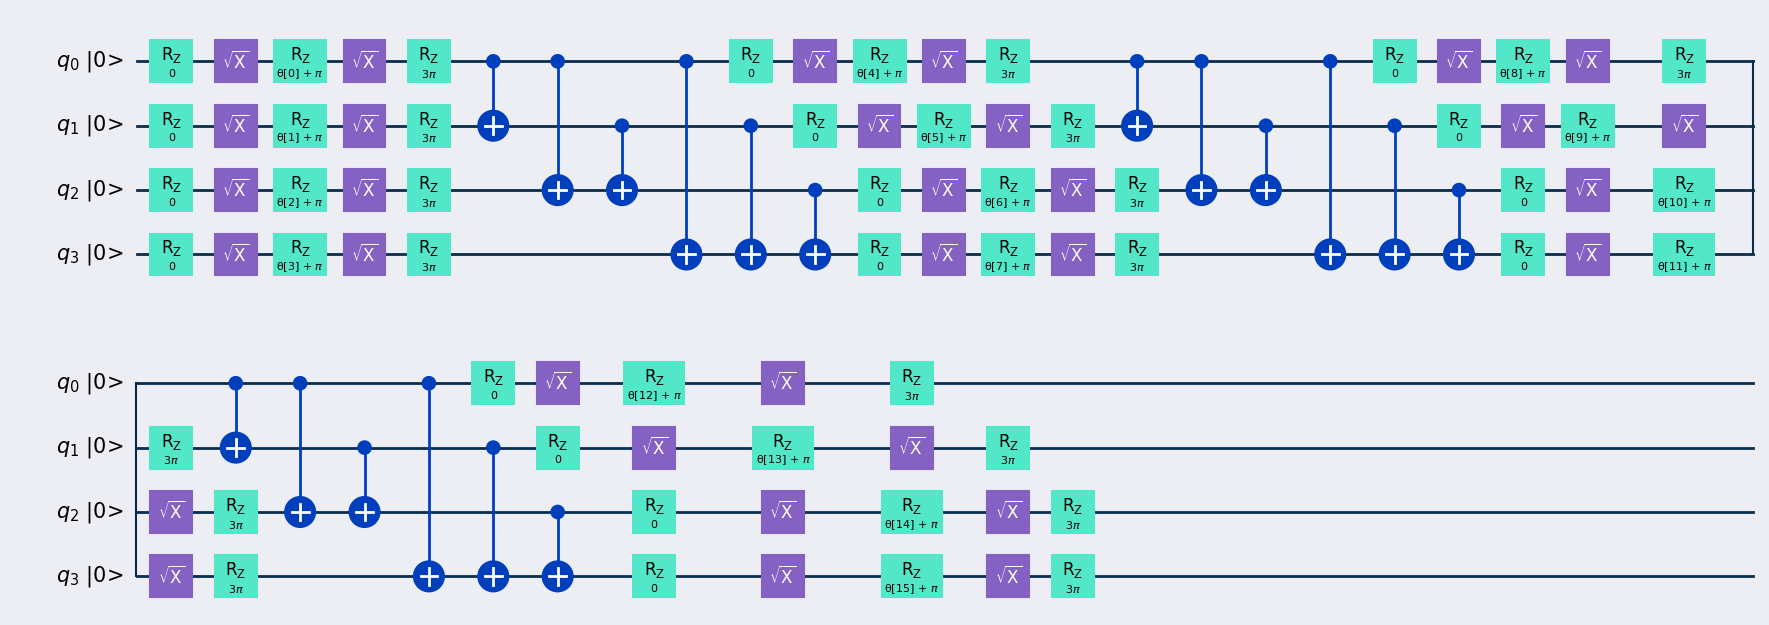

In [13]:
vqe_min_energy.ansatz.draw('mpl', initial_state=True, style=qspain())

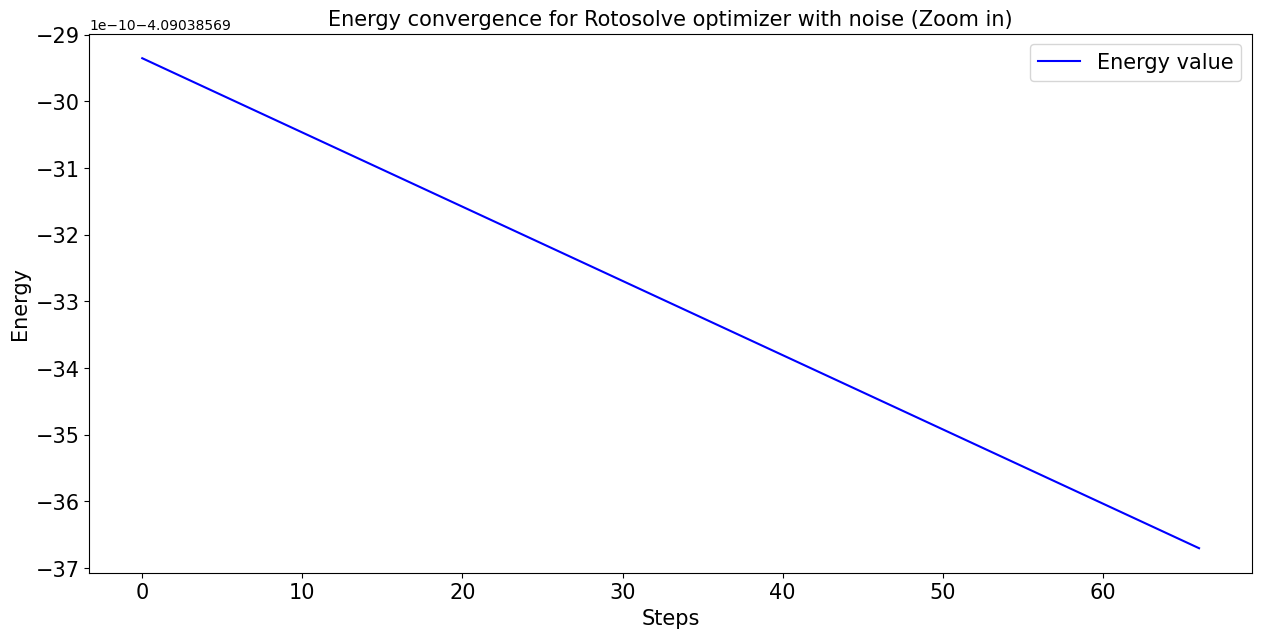

In [14]:
'''Qiskit_code_cell'''

sim_noisy_values = optimizer_noise.energy_values
fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(sim_noisy_values)), sim_noisy_values, label="Energy value", color='blue')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Steps', fontsize = fontsize)
plt.ylabel('Energy', fontsize = fontsize)
#plt.ylim([np.min(sim_noisy_values), np.max(sim_noisy_values)])
plt.title('Energy convergence for Rotosolve optimizer with noise (Zoom in)', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize);
plt.show()

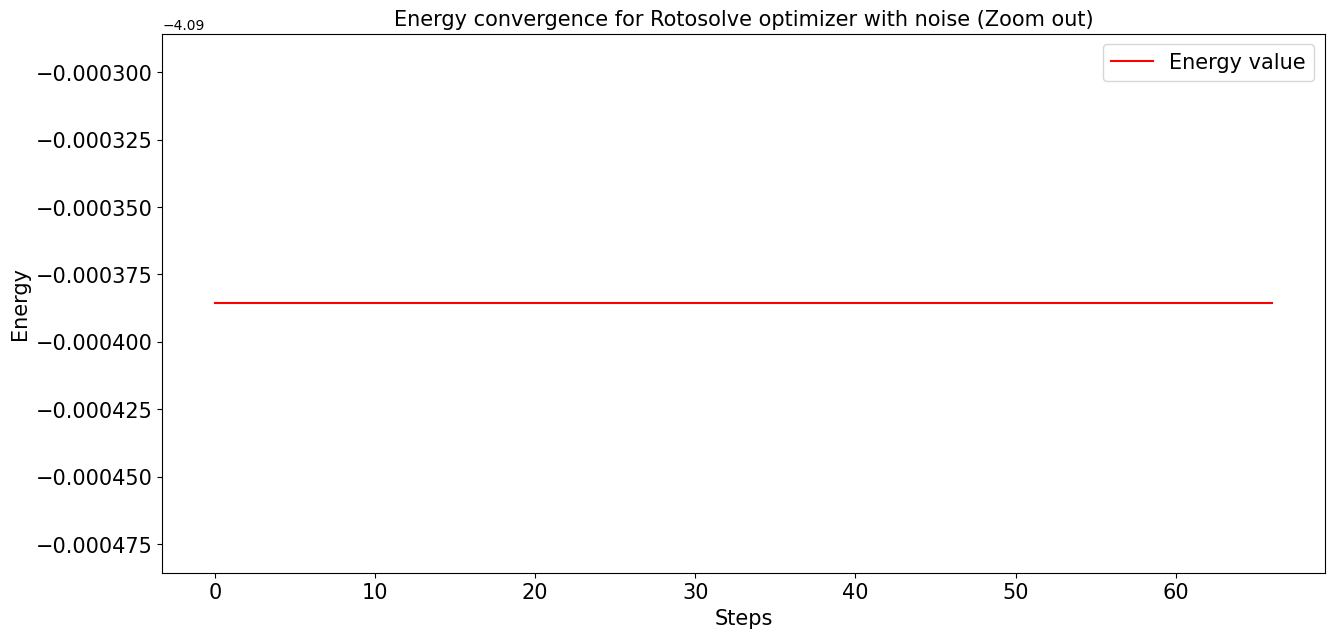

In [15]:
'''Qiskit_code_cell'''

sim_noisy_values = optimizer_noise.energy_values
fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(sim_noisy_values)), sim_noisy_values, label="Energy value", color='red')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Steps', fontsize = fontsize)
plt.ylabel('Energy', fontsize = fontsize)

eig_val = result_sim.eigenvalue.real
plt.ylim([eig_val - 1e-4, eig_val + 1e-4])
plt.title('Energy convergence for Rotosolve optimizer with noise (Zoom out)', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize);
plt.show()

In [16]:
'''Pennylane_code_cell'''

# Definimos el Hamiltoniano
n = 4 # número de qubits
gam = 0.3

H = ising_chain_ham(n, gam, pennylane = True) # Creamos el Hamiltoniano descrito
#H = qml.Hamiltonian(H.coeffs, H.ops)
print("Estructura del Hamiltoniano en matrices de Pauli:")
print("--------------------------------------------------\n")
print(H)

Estructura del Hamiltoniano en matrices de Pauli:
--------------------------------------------------

  (0.29999999999999993) [I0 Z1 I2 I3]
+ (0.29999999999999993) [Z0 I1 I2 I3]
+ (0.3) [I0 I1 I2 Z3]
+ (0.3) [I0 I1 Z2 I3]
+ (1.0) [I0 I1 X2 X3]
+ (1.0) [I0 X1 X2 I3]
+ (1.0) [X0 I1 I2 X3]
+ (1.0) [X0 X1 I2 I3]


In [17]:
'''Pennylane_code_cell'''

dev = qml.device("lightning.qubit", wires = n) # pennylane simulator

init_param = (
    np.array(np.random.random(n), requires_grad=True),
    np.array(1.1, requires_grad=True),
    np.array(np.random.random(n), requires_grad=True),
)

rot_weights = np.ones(n)
crot_weights = np.ones(n)

nums_frequency = {
    "rot_param": {(0,): 1, (1,): 1, (2,): 1., (3,): 1.}, # parámetros iniciales para las rotaciones de puertas
    "layer_par": {(): n},
    "crot_param": {(0,): 2, (1,): 2, (2,): 2, (3,): 2},
}

@qml.qnode(dev)
def ansatz(rot_param, layer_par, crot_param, rot_weights = None, crot_weights = None):
    
    # Ansatz
    # la selección del ansatz impacta en el cómputo de la solución. Se debe probar qué ansatz es mejor en cada caso
    for i, par in enumerate(rot_param * rot_weights):
        qml.RY(par, wires = i)
            
    for _ in list(range(len(dev.wires))):

        qml.CNOT(wires = [0, 1])
        qml.CNOT(wires = [0, 2])
        qml.CNOT(wires = [1, 2])
        qml.CNOT(wires = [0, 3])
        qml.CNOT(wires = [1, 3])
        qml.CNOT(wires = [2, 3])
        
    # Medimos el valor esperado del Hamiltoniano
    return qml.expval(H)

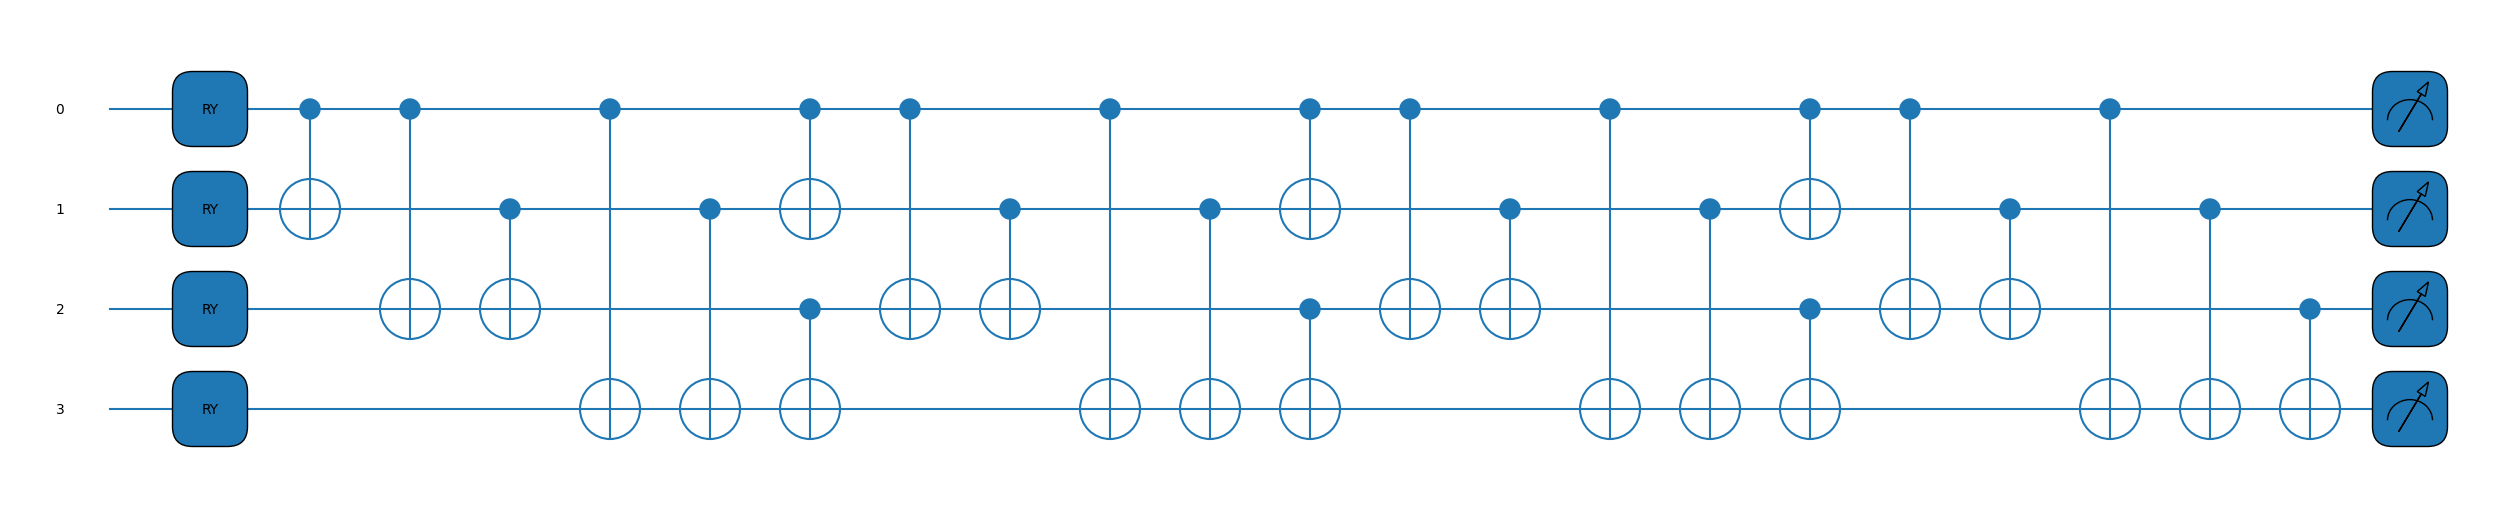

In [18]:
'''Pennylane_code_cell'''

# https://docs.pennylane.ai/en/stable/code/api/pennylane.draw_mpl.html
# Dibujamos el circuito con pennylane
fig, _ = qml.draw_mpl(ansatz, style="default", fontsize = "medium")(*init_param, rot_weights = rot_weights, crot_weights = crot_weights)
fig.show()

In [19]:
'''Pennylane_code_cell'''

if not CONFIGURATION['JSON_RESULT']:

    max_iterations = 500 # número de iteraciones de rotosolve
    
    # Usamos el optimizadpr Rotosolve que viene implementado en Pennylane
    opt = qml.RotosolveOptimizer(substep_optimizer = "brute", substep_kwargs = {"num_steps": 4})
    
    param = init_param
    
    rot_weights = np.array([0.4, 0.8, 1.0, 1.2], requires_grad=False)
    crot_weights = np.array([0.5, 1.0, 1.5, 1.8], requires_grad=False)
    
    cost_rotosolve = []
    
    for n in range(max_iterations):
    
        param, cost, prev_energy = opt.step_and_cost(
             ansatz,
             *param,
             nums_frequency=nums_frequency,
             spectra = [],
             full_output=True,
             rot_weights=rot_weights,
             crot_weights=crot_weights,
        )
    
        # Compute energy
        energy = ansatz(*param, rot_weights=rot_weights, crot_weights=crot_weights)
    
        # Calculate difference between new and old energies
        conv = np.abs(energy - prev_energy)
        
        if n % 10 == 0:
            print("Iteration = {:},  Energy = {:.15f} Ha,  Convergence parameter = {:.15f} Ha".format(n, energy, np.mean(conv)))
    
        cost_rotosolve.extend(prev_energy)
    
    print("\n==================================")
    print("Number of iterations = ", max_iterations)
    print("Last energy value = ", cost_rotosolve[len(cost_rotosolve) - 1])
else:
    
    with open('./utils/results/vqe-rotosolve-pennylane.json') as user_file:
            json_dict = user_file.read()
    
    cost_rotosolve = json.loads(json_dict)

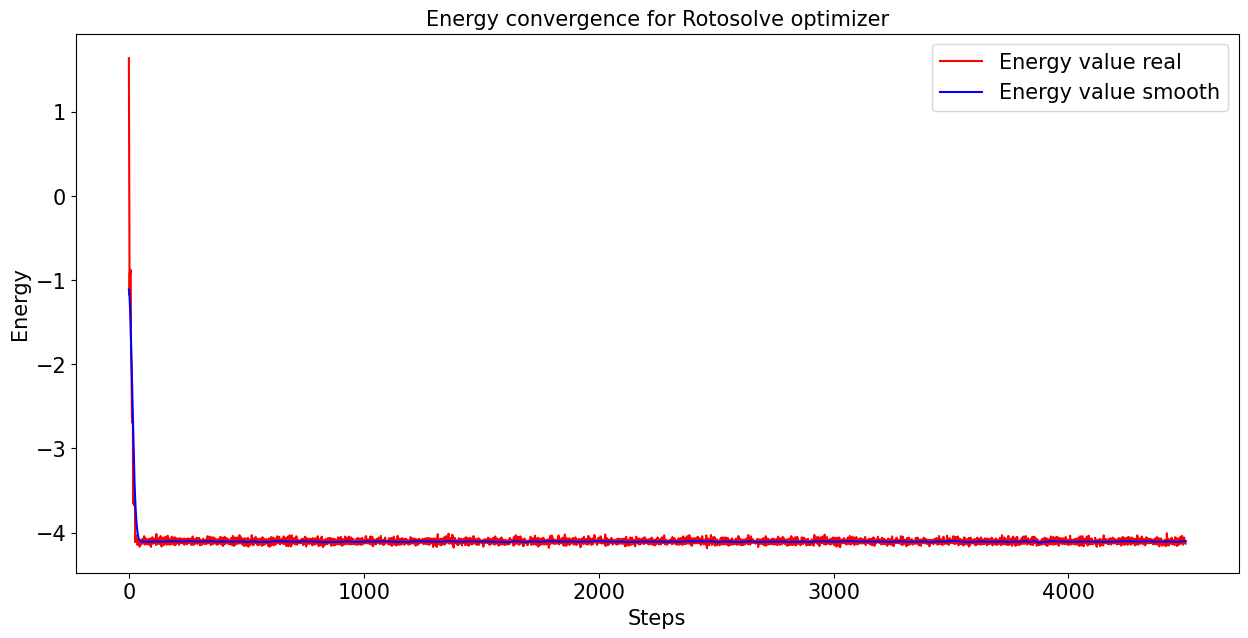

In [20]:
'''Pennylane_code_cell'''

def smooth(data):
    return gaussian_filter(data, sigma=10, mode='reflect', truncate=18.0)

fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(cost_rotosolve)), cost_rotosolve, label="Energy value real", color='red')
plt.plot(range(len(cost_rotosolve)), smooth(cost_rotosolve), label="Energy value smooth", color='blue')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Steps', fontsize = fontsize)
plt.ylabel('Energy', fontsize = fontsize)

plt.title('Energy convergence for Rotosolve optimizer', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize);
plt.show()

In [21]:
# Set your accout token here for ibmq --> https://quantum-computing.ibm.com/
QISKIT_TOKEN = "" 

if QISKIT_TOKEN != "":
    IBMQ.save_account(QISKIT_TOKEN, overwrite=True)
    print("Token IBMQ guardado!")

    provider = IBMQ()
    print("Provider Instance: ", provider.active_account()['instance'])
    print("Provider Channel: ", provider.active_account()['channel'])
#else:
#    pass # Skip token check
#    raise("Token no encontrado. Regístrate en https://quantum-computing.ibm.com/ para obtener el token y usar un backend real")

In [22]:
'''Pennylane_code_cell'''

# Definimos el Hamiltoniano
n = 4 # número de qubits
gam = 0.3

H = ising_chain_ham(n, gam, pennylane = True) # Creamos el Hamiltoniano descrito

print("Estructura del Hamiltoniano en matrices de Pauli:")
print("--------------------------------------------------\n")
print(H)

Estructura del Hamiltoniano en matrices de Pauli:
--------------------------------------------------

  (0.29999999999999993) [I0 Z1 I2 I3]
+ (0.29999999999999993) [Z0 I1 I2 I3]
+ (0.3) [I0 I1 I2 Z3]
+ (0.3) [I0 I1 Z2 I3]
+ (1.0) [I0 I1 X2 X3]
+ (1.0) [I0 X1 X2 I3]
+ (1.0) [X0 I1 I2 X3]
+ (1.0) [X0 X1 I2 I3]


In [23]:
'''Pennylane_code_cell'''

def ansatz_backend(params):

    wires = int(params[4])
    rot_param = np.array(params[0:4])
    rot_weights = np.array(params[5:])
    
    for i, par in enumerate(rot_param * rot_weights):
        qml.RY(par, wires = i)
            
    for _ in list(range(wires)):
       
        qml.CNOT(wires = [0, 1])
        qml.CNOT(wires = [0, 2])
        qml.CNOT(wires = [1, 2])
        qml.CNOT(wires = [0, 3])
        qml.CNOT(wires = [1, 3])
        qml.CNOT(wires = [2, 3])

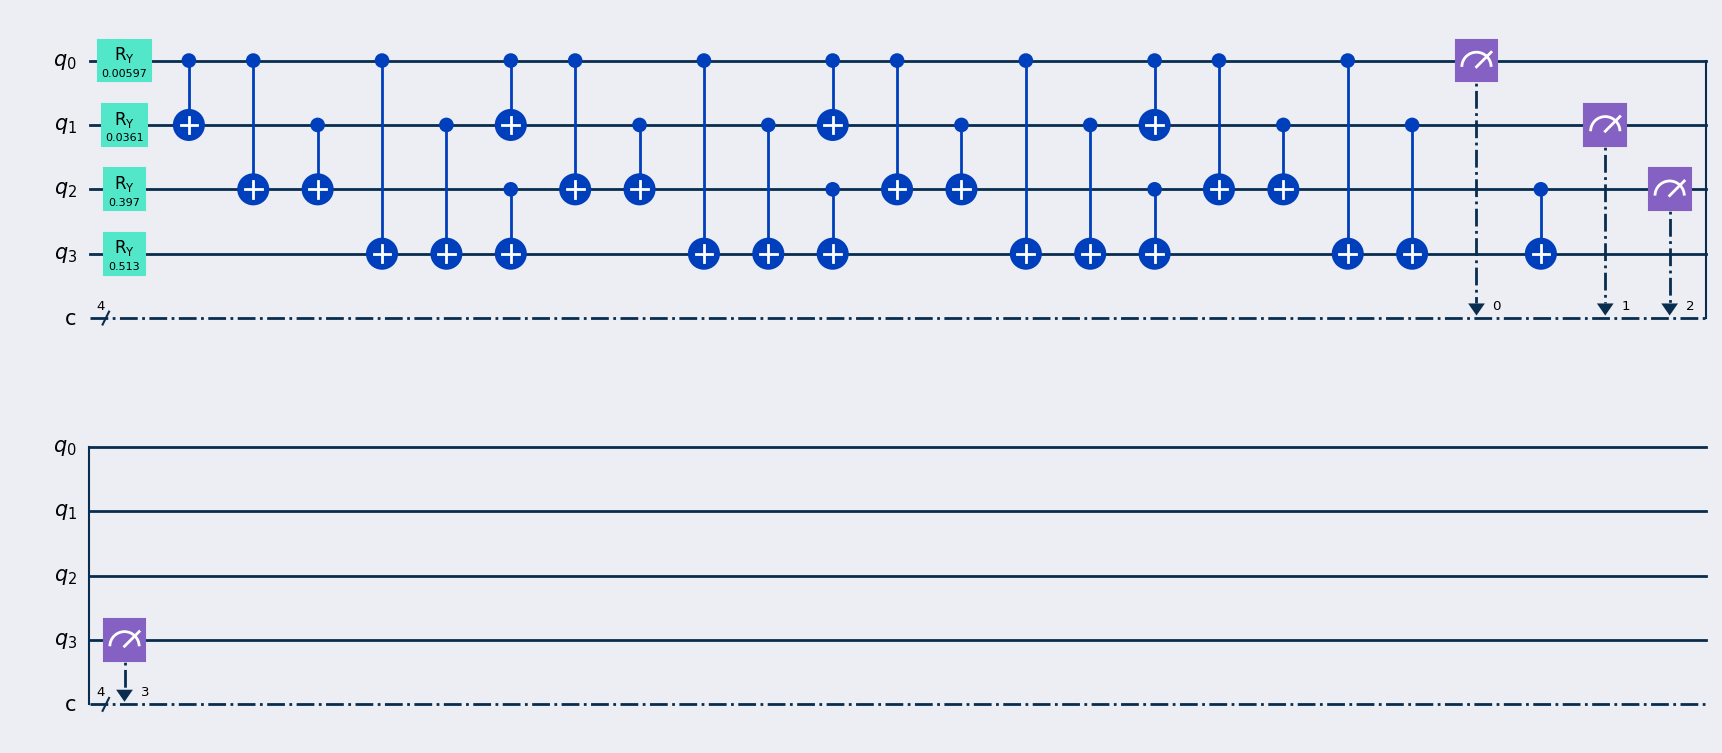

In [24]:
'''Pennylane_code_cell'''

rot_weights = np.array([0.4, 0.8, 1.0, 1.2], requires_grad=False)
crot_weights = np.array([0.5, 1.0, 1.5, 1.8], requires_grad=False)

n_wires = 4
init_param = [*np.array(np.random.random(n_wires), requires_grad=True), n_wires, *np.array(np.random.random(4), requires_grad=True)]

print_pennylane_circuit(ansatz_backend, init_param, n_wires, qiskit = True, qsstyle = True)

In [25]:
'''Pennylane_code_cell'''

RECOVER_RESULT = True

if RECOVER_RESULT:
    
    with open('./utils/results/vqe-runtime-V3kAkm9J2p.json') as js:
        data = json.load(js)
    
    results = data['intermediate_results']
    
else:

    num_qubits = 4
    init_param = [*np.array(np.random.random(num_qubits), requires_grad=True), n_wires, *np.array(np.random.random(4), requires_grad=True)]

    dev = qml.device('qiskit.ibmq', wires = num_qubits, backend='ibmq_osaka', ibmqx_token=QISKIT_TOKEN) # real device
    #dev = qml.device("lightning.qubit", wires = num_qubits) # pennylane simulator

    results = []

    def circuit(p):
        ansatz_backend(p)
        return qml.expval(H)

    cost_function = qml.QNode(circuit, dev)
    
    opt = qml.GradientDescentOptimizer(stepsize=0.1)

    params = init_param
    ntrials = 50

    for n in range(ntrials):
        params, new_energy = opt.step_and_cost(cost_function, params)

        print(f"--- Step: {n}, Energy: {new_energy:.12f}")
            
        results.append(new_energy)

In [26]:
print("Energía mínima:", np.min(results))

Energía mínima: -2.22177734375


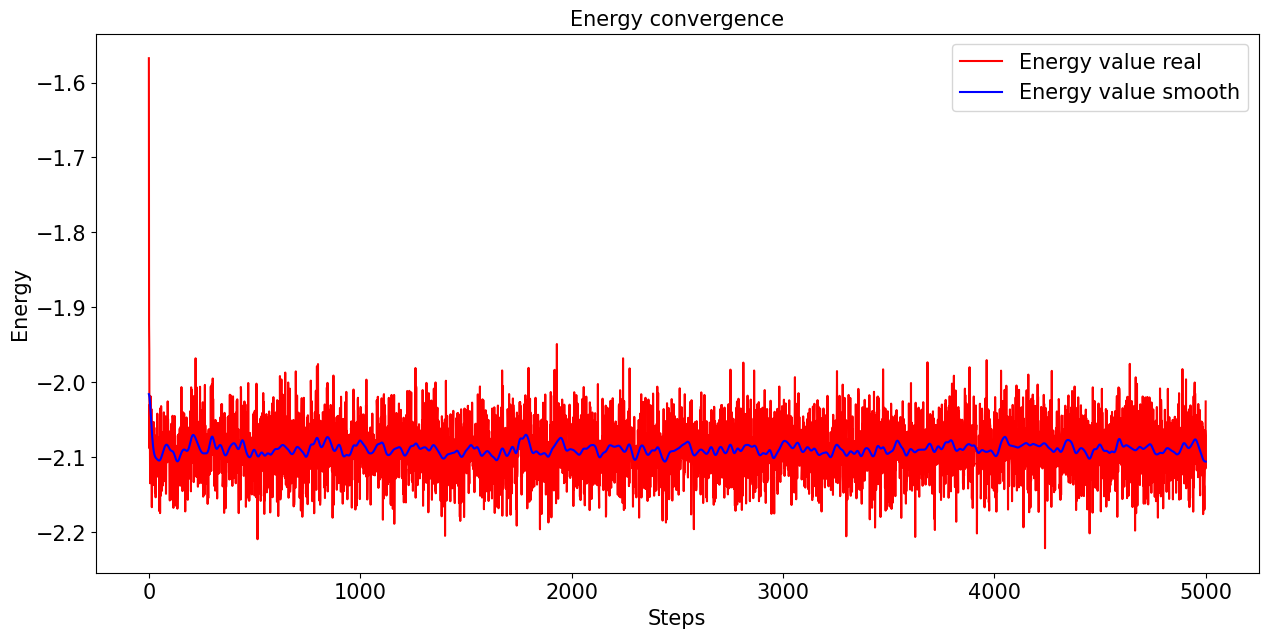

In [27]:
'''Pennylane_code_cell'''

def smooth(data):
    return gaussian_filter(data, sigma=10, mode='reflect', truncate=18.0)

fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(results)), results, label="Energy value real", color='red')
plt.plot(range(len(results)), smooth(results), label="Energy value smooth", color='blue')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Steps', fontsize = fontsize)
plt.ylabel('Energy', fontsize = fontsize)

plt.title('Energy convergence', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize);
plt.show()

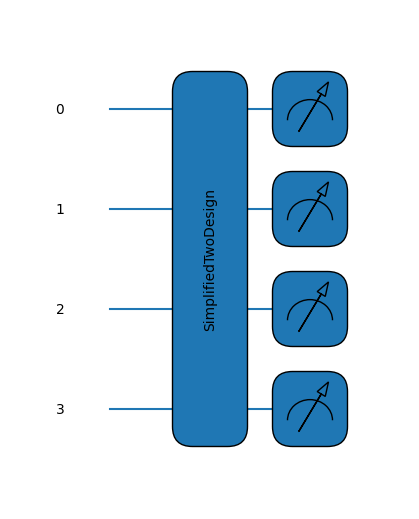

In [28]:
'''Pennylane_code_cell'''

def ansatz_backend2(params):
    
    n_wires = int(params[len(params) - 1])
    
    init_weights = list(params[0:4])
    
    weights1 = np.array(np.array_split(params[4:10], 3))
    weights2 = np.array(np.array_split(params[10:16], 3))
    weights3 = np.array(np.array_split(params[16:22], 3))
    weights = np.array([weights1, weights2, weights3])
    
    # https://docs.pennylane.ai/en/stable/code/api/pennylane.SimplifiedTwoDesign.html
    qml.SimplifiedTwoDesign(initial_layer_weights = init_weights, weights = weights, wires = range(n_wires))

'''Pennylane_code_cell'''

n_params = 22
n_wires = 4
init_params = []

for _ in list(range(n_params)):
    rnd_value = np.random.random(2).tolist()
    init_params.append(rnd_value[0])
    init_params.append(rnd_value[1])

init_params.append(n_wires)

print_pennylane_circuit(ansatz_backend2, init_params, n_wires, qiskit = False, qsstyle = False)

In [29]:
'''Pennylane_code_cell'''

RECOVER_RESULT = True

if RECOVER_RESULT:
    
    with open('./utils/results/vqe-runtime-d3lj4Na0Wp.json') as js:
        data = json.load(js)
    
    results_ansatz2 = data['intermediate_results']
    
else:

    #dev = qml.device('qiskit.ibmq', wires = num_qubits, backend='ibmq_qasm_simulator', ibmqx_token=QISKIT_TOKEN) # real device
    dev = qml.device("lightning.qubit", wires = num_qubits) # pennylane simulator
    
    results = []

    def circuit(p):
        ansatz_backend2(p)
        return qml.expval(H)

    cost_function = qml.QNode(circuit, dev)
    
    opt = qml.GradientDescentOptimizer(stepsize=0.1)

    params = init_params
    ntrials = 50

    for n in range(ntrials):
        params, new_energy = opt.step_and_cost(cost_function, params)

        print(f"--- Step: {n}, Energy: {new_energy:.12f}")
            
        results.append(new_energy)

In [30]:
print("Energía mínima:", np.min(results_ansatz2))

Energía mínima: -2.949609375


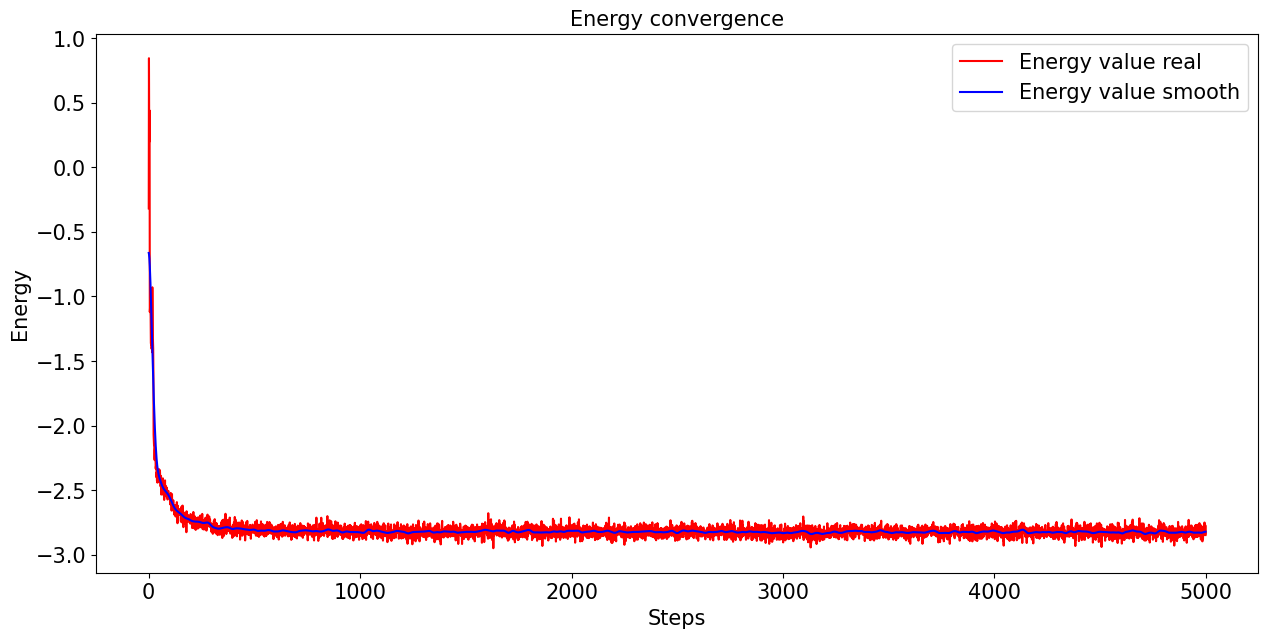

In [31]:
'''Pennylane_code_cell'''

def smooth(data):
    return gaussian_filter(data, sigma=10, mode='reflect', truncate=18.0)

fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(results_ansatz2)), results_ansatz2, label="Energy value real", color='red')
plt.plot(range(len(results_ansatz2)), smooth(results_ansatz2), label="Energy value smooth", color='blue')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Steps', fontsize = fontsize)
plt.ylabel('Energy', fontsize = fontsize)

plt.title('Energy convergence', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize);
plt.show()

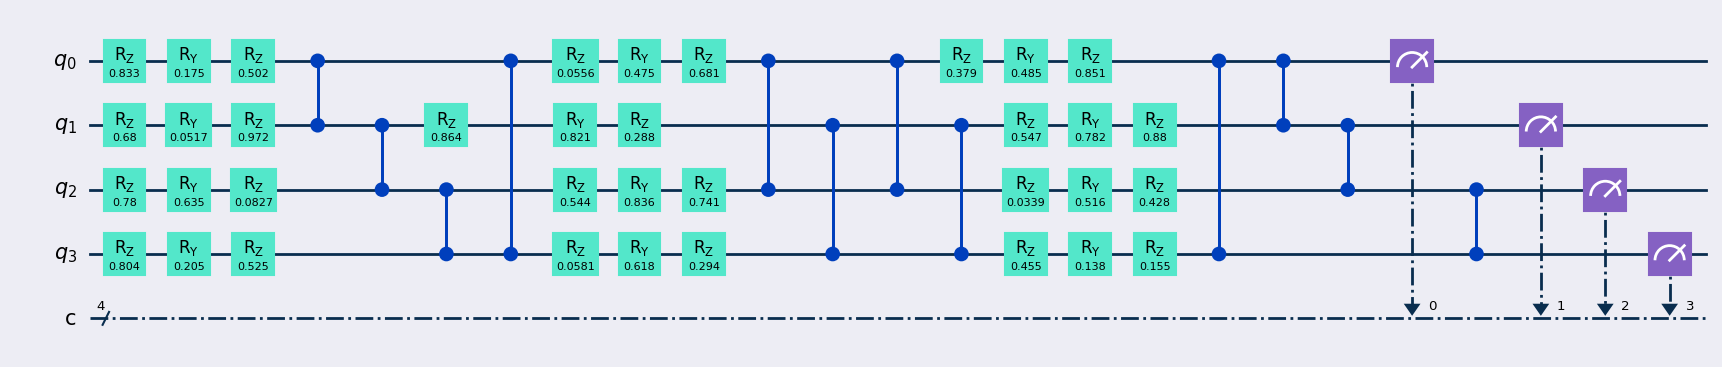

In [32]:
'''Pennylane_code_cell'''

n_wires = 4

def ansatz_backend3(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(n_wires), ranges=range(1, n_wires), imprimitive=qml.ops.CZ)

shape = qml.StronglyEntanglingLayers.shape(n_layers=n_wires-1, n_wires=n_wires)
weights_entangled = np.random.random(size=shape)

print_pennylane_circuit(ansatz_backend3, weights_entangled, n_wires, qiskit = True, qsstyle = True)

In [33]:
import qiskit.tools.jupyter
%qiskit_version_table

In [34]:
qml.about()

Name: PennyLane
Version: 0.34.0
Summary: PennyLane is a Python quantum machine learning library by Xanadu Inc.
Home-page: https://github.com/PennyLaneAI/pennylane
Author: 
Author-email: 
License: Apache License 2.0
Location: /home/dcb/Programs/miniconda/miniconda3/envs/qiskit_qibo_penny_2/lib/python3.11/site-packages
Requires: appdirs, autograd, autoray, cachetools, networkx, numpy, pennylane-lightning, requests, rustworkx, scipy, semantic-version, toml, typing-extensions
Required-by: PennyLane-Lightning, PennyLane-qiskit

Platform info:           Linux-6.8.9-1-default-x86_64-with-glibc2.39
Python version:          3.11.7
Numpy version:           1.24.1
Scipy version:           1.12.0
Installed devices:
- lightning.qubit (PennyLane-Lightning-0.34.0)
- default.gaussian (PennyLane-0.34.0)
- default.mixed (PennyLane-0.34.0)
- default.qubit (PennyLane-0.34.0)
- default.qubit.autograd (PennyLane-0.34.0)
- default.qubit.jax (PennyLane-0.34.0)
- default.qubit.legacy (PennyLane-0.34.0)
- defau